In [1]:
import spacy
sp = spacy.load('en')

In [2]:
import re
import os
import random
from collections import Counter

import numpy
import scipy
import pandas
import nearpy
from bs4 import BeautifulSoup
from scipy import signal

import matplotlib
%matplotlib inline

In [3]:
### Script Settings ###

# Modify these to change input files and other parameters.

# Input filenames:
home_folder = '../../../../'
original_script_filename = os.path.join(
    home_folder, 
    'original-scripts/force-awakens/force-awakens-dialogue-only.txt'
)
fan_work_directory = os.path.join(
    home_folder, 
    'fan-works/force-awakens-fullset/plaintext'
)

# Set N-Gram window size:
window_size = 10

# Set cosine distance matching threshold:
distance_threshold = 0.25

# Set approximate nearest neighbor parameters:
number_of_hashes = 15  # Bigger -> slower (linear), more matches
hash_dimensions = 14   # Bigger -> faster (???), fewer matches

In [4]:
# This cell is commented out until we need Bokeh.

#import bokeh.io
#from bokeh.io import push_notebook, show, output_notebook
#from bokeh.plotting import figure
#from bokeh.resources import INLINE
#from bokeh.models import Range1d

#from time import sleep
#output_notebook(resources=INLINE)
#sleep(1)                  # Otherwise `Run All` messes things up; 
#bokeh.io._nb_loaded=True  # see https://github.com/bokeh/bokeh/issues/4987

In [5]:
# Utility functions

def mk_vectors(sp_txt):
    """Given a parsed text in `spacy`'s native format, produce
    a sequence of vectors, one per token.
    """
    rows = len(sp_txt)
    cols = len(sp_txt[0].vector if rows else 0)
    vectors = numpy.empty((rows, cols), dtype=float)
    for i, word in enumerate(sp_txt):
        if word.has_vector:
            vectors[i] = word.vector
        else:
            # It seems `spacy` doesn't have a pre-trained vector for
            # this word. So we do something pretty dumb here to give
            # the word a vector that is unique to that word and not
            # too similar to other words.
            w_str = str(word)
            vectors[i] = 0
            vectors[i][hash(w_str) % cols] = 1.0
            vectors[i][hash(w_str * 2) % cols] = 1.0
            vectors[i][hash(w_str * 3) % cols] = 1.0
    return vectors

def cosine_distance(row_values, col_values):
    """Calculate the cosine distance between two vectos. Also
    accepts matrices and 2-d arrays, and calculates the 
    distances over the cross product of rows and columns.
    """
    verr_msg = '`cosine_distance` is not defined for {}-dimensional arrays.'
    if len(row_values.shape) == 1:
        row_values = row_values[None,:]
    elif len(row_values.shape) != 2:
        raise ValueError(verr_msg.format(len(row_values.shape)))
    
    if len(col_values.shape) == 1:
        col_values = col_values[:,None]
    elif len(col_values.shape) != 2:
        raise ValueError(verr_msg.format(len(col_values.shape)))

    row_norm = (row_values * row_values).sum(axis=1) ** 0.5
    row_norm = row_norm[:,None]
    
    col_norm = (col_values * col_values).sum(axis=0) ** 0.5
    col_norm = col_norm[None,:]

    result = row_values @ col_values
    result /= row_norm
    result /= col_norm
    return 1 - result

In [6]:
# Load original script:

with open(original_script_filename) as orig_in:
    orig_txt = orig_in.read()
    orig_txt = re.sub(r'\s+', ' ', orig_txt).strip()
    orig = sp(orig_txt)

In [7]:
# Build the ngram vectors using rolling windows. 
# Variables named `*_win_vectors` contain vectors for
# the given input, such that each row is the vector
# for a single window. Successive windows overlap
# at all words except for the first and last.
orig_vectors = mk_vectors(orig)
orig_win_vectors = numpy.array([orig_vectors[i:i + window_size, :].ravel()
                                for i in range(orig_vectors.shape[0] - window_size + 1)])

# Initialize the approximate nearest neighbor search algorithm.
# This creates the search "engine" and populates its index with
# the window-vectors from the original script. We can then pass
# over the window-vectors from a fan work, taking each vector
# and searching for good matches in the engine's index of script
# text.

# We could do the search in the opposite direction, storing 
# fan text in the engine's index, and passing over window-
# vectors from the original script, searching for matches in 
# the index of fan text. Unfortuantely, the quality of the 
# matches found goes down when you add too many values to the
# engine's index.
vector_dim = orig_win_vectors.shape[1]
hashes = []
for i in range(number_of_hashes):
    h = nearpy.hashes.RandomBinaryProjections('rbp{}'.format(i),
                                              hash_dimensions)
    hashes.append(h)

engine = nearpy.Engine(vector_dim,
                       lshashes=hashes,
                       distance=nearpy.distances.CosineDistance())

In [8]:
for ix, row in enumerate(orig_win_vectors):
    engine.store_vector(row, (ix, str(orig[ix: ix + window_size])))

In [9]:
orig_match_count = Counter()

# Load fan work:

fan_works = os.listdir(fan_work_directory)
fan_works = [os.path.join(fan_work_directory, f) 
             for f in fan_works]
random.seed(4815162342)  # This will always generate the same "random" sample.
random.shuffle(fan_works)

records = []
for fan_filename in fan_works[0:50]:
    with open(fan_filename) as fan_file:
        fan = sp(fan_file.read())
    
    # Create the fan windows:
    fan_vectors = mk_vectors(fan)
    fan_win_vectors = numpy.array([fan_vectors[i:i + window_size, :].ravel()
                                   for i in range(fan_vectors.shape[0] - window_size + 1)])

    max_fan_windows = fan_win_vectors.shape[0]
    for i, row in enumerate(fan_win_vectors):
        fast_results = engine.neighbours(row)
        fast_results = fast_results[0:1]
        fast_results = [(match_ix, match_str, distance) 
                        for vec, (match_ix, match_str), distance in fast_results 
                        if distance < distance_threshold]

        if i % 1000 == 0: 
            print('* {}/{} fan windows processed...'.format(i, max_fan_windows))

        if fast_results:
            print()
            print('----------------')
            print('* Matches found!')
            print('    Fan window    (at index {:>6}):   {}'.format(i, fan[i: i + window_size]))
            print()       
            print("* Approximate best matches (fast)")
            for match_ix, match_str, distance in fast_results:
                print('    Script window (at index {:>6}):   {}'.format(match_ix, match_str))
                print('    Cosine distance between windows:   {}'.format(distance))
                print()
                
                # records.append([fan_filename, i, match_ix, char, distance])
                orig_match_count[match_ix] += 1

* 0/2631 fan windows processed...
* 1000/2631 fan windows processed...
* 2000/2631 fan windows processed...
* 0/514 fan windows processed...
* 0/737 fan windows processed...
* 0/9370 fan windows processed...

----------------
* Matches found!
    Fan window    (at index    250):   . I didn't realize when we came here I

* Approximate best matches (fast)
    Script window (at index   4862):   . I know you do. That's why I
    Cosine distance between windows:   0.2452194735562201

* 1000/9370 fan windows processed...
* 2000/9370 fan windows processed...
* 3000/9370 fan windows processed...

----------------
* Matches found!
    Fan window    (at index   3071):   a new one. Uh, yeah, I have

* Approximate best matches (fast)
    Script window (at index   6521):   She's gone. Yeah, yeah, I know
    Cosine distance between windows:   0.20218996866057082


----------------
* Matches found!
    Fan window    (at index   3072):   new one. Uh, yeah, I have a

* Approximate best matches (fast)
 

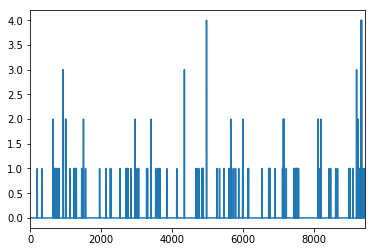

In [10]:
maxn = max(orig_match_count.keys())
pandas.Series([orig_match_count[n] for n in range(maxn + 1)]).plot()

In [11]:
print("Most often imitated portions of the original script.")
print()
print("The imitated phrase appears between <<brakcets>>.")
print("Text outside brackets is provided for context, and ")
print("you can adjust how much context appears by modifying ")
print("`context_width` above.")
print()
print()

# Size of 
context_width = 5

for ix, n in orig_match_count.most_common(20):
    print('{} <<{}>> {}'.format(orig[ix - context_width: ix],
                                orig[ix: ix + window_size],
                                orig[ix + window_size: ix + window_size + context_width]))
    print()

Most often imitated portions of the original script.

The imitated phrase appears between <<brakcets>>.
Text outside brackets is provided for context, and 
you can adjust how much context appears by modifying 
`context_width` above.


this pain. I know <<what I have to do but I don't know>> if I have the strength

know what I have to <<do but I don't know if I have the>> strength to do it.

offering me a job? <<I wouldn't be nice to you. I do>> n't pay much. You

be free of this pain <<. I know what I have to do but I>> don't know if I

to me. Even you <<, Master of the Knights of Ren, have never>> faced such a test.

me a job? I <<wouldn't be nice to you. I don't>> pay much. You're

. If you do exactly <<as I say, I can get you out of>> here. What? This

that mask. You do <<n't need it. What do you think you'll>> see if I do?

n't leave without me. <<You can't just go. I won't let>> you. I'm not

That's what Snoke wants <<you to believe, but it's not true.>> My son is alive.

free of 